## Testing and visualizing the activations of the diffusion language model LLADA.

In [3]:
import torch
import os
import copy
from model.modeling_llada import LLaDAModelLM

# Configuration
BASE_MODEL_PATH = "GSAI-ML/LLaDA-8B-Instruct"
SMOOTHQUANT_MODEL_PATH = "models/llada_smoothquant.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Load base model first
print(f"Loading base model from {BASE_MODEL_PATH}...")
base_model = LLaDAModelLM.from_pretrained(
    BASE_MODEL_PATH,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
).to(DEVICE)

smoothed_model = copy.deepcopy(base_model)


# Load smoothquant state dict
print(f"Loading smoothquant weights from {SMOOTHQUANT_MODEL_PATH}...")
state_dict = torch.load(SMOOTHQUANT_MODEL_PATH, map_location=DEVICE, weights_only=True)
smoothed_model.load_state_dict(state_dict, strict=False)

base_model.eval()
smoothed_model.eval()

Loading base model from GSAI-ML/LLaDA-8B-Instruct...


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00, 211.53it/s]


Loading smoothquant weights from models/llada_smoothquant.pt...


LLaDAModelLM(
  (model): LLaDAModel(
    (transformer): ModuleDict(
      (wte): Embedding(126464, 4096)
      (emb_drop): Dropout(p=0.0, inplace=False)
      (ln_f): RMSLayerNorm()
      (blocks): ModuleList(
        (0-31): 32 x LLaDALlamaBlock(
          (dropout): Dropout(p=0.0, inplace=False)
          (act): SiLU()
          (attn_out): Linear(in_features=4096, out_features=4096, bias=False)
          (ff_out): Linear(in_features=12288, out_features=4096, bias=False)
          (rotary_emb): RotaryEmbedding()
          (attn_norm): RMSLayerNorm()
          (ff_norm): RMSLayerNorm()
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (ff_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
        )
      )
    

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from quantization_calibration_dataset import LLaDACalibrationDataset
import torch.nn as nn

class ActivationVisualizer:
    """Captures activations for 3D visualization."""
    
    def __init__(self, model, max_layers=10, downsample_factor=4):
        """
        Args:
            model: The model to visualize
            max_layers: Maximum number of layers to capture
            downsample_factor: Factor to downsample activations for visualization
        """
        self.model = model
        self.hooks = []
        self.activations = {}
        self.max_layers = max_layers
        self.downsample_factor = downsample_factor
        self.layer_count = 0
    
    def _hook_fn(self, name):
        def hook(module, input, output):
            if self.layer_count >= self.max_layers:
                return
            x = input[0].detach().cpu()
            # Store activation: shape is typically [batch, seq_len, hidden_dim]
            # Downsample for visualization if needed
            if x.dim() == 3:
                # Downsample sequence length and hidden dim for visualization
                seq_len = x.shape[1]
                hidden_dim = x.shape[2]
                seq_downsample = max(1, seq_len // self.downsample_factor)
                hidden_downsample = max(1, hidden_dim // self.downsample_factor)
                
                # Sample evenly
                seq_indices = torch.linspace(0, seq_len - 1, seq_downsample, dtype=torch.long)
                hidden_indices = torch.linspace(0, hidden_dim - 1, hidden_downsample, dtype=torch.long)
                
                # Take first batch, then sample using PyTorch indexing
                x_batch0 = x[0]  # [seq_len, hidden_dim]
                x_sampled = x_batch0[seq_indices[:, None], hidden_indices]  # [seq_downsample, hidden_downsample]
                # Convert to float32 for numpy compatibility, then to numpy
                self.activations[name] = x_sampled.float().numpy()
            elif x.dim() == 2:
                # [seq_len, hidden_dim] - already 2D
                seq_len = x.shape[0]
                hidden_dim = x.shape[1]
                seq_downsample = max(1, seq_len // self.downsample_factor)
                hidden_downsample = max(1, hidden_dim // self.downsample_factor)
                
                seq_indices = torch.linspace(0, seq_len - 1, seq_downsample, dtype=torch.long)
                hidden_indices = torch.linspace(0, hidden_dim - 1, hidden_downsample, dtype=torch.long)
                
                x_sampled = x[seq_indices[:, None], hidden_indices]
                # Convert to float32 for numpy compatibility, then to numpy
                self.activations[name] = x_sampled.float().numpy()
            else:
                # Flatten and reshape if needed
                x_flat = x.flatten()
                if len(x_flat) > 10000:
                    # Sample if too large
                    indices = torch.linspace(0, len(x_flat) - 1, 10000, dtype=torch.long)
                    x_sampled = x_flat[indices].float().numpy()
                else:
                    x_sampled = x_flat.float().numpy()
                self.activations[name] = x_sampled
            
            self.layer_count += 1
        return hook
    
    def register_hooks(self, layer_names=None):
        """Register hooks on specified layers or all Linear layers."""
        count = 0
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                if layer_names is None or any(layer_name in name for layer_name in layer_names):
                    self.hooks.append(module.register_forward_hook(self._hook_fn(name)))
                    count += 1
                    if count >= self.max_layers:
                        break
        print(f"Registered hooks on {len(self.hooks)} layers")
    
    def clear_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.layer_count = 0
    
    def capture(self, input_ids):
        """Capture activations for given input."""
        self.activations = {}
        self.layer_count = 0
        with torch.no_grad():
            _ = self.model(input_ids=input_ids)
        return self.activations

print("ActivationVisualizer class defined")

ActivationVisualizer class defined


In [6]:
# Prepare input data
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_PATH, trust_remote_code=True)
dataset = LLaDACalibrationDataset(
    tokenizer=tokenizer,
    seq_len=256,  # Shorter for faster visualization
    samples=1,
    block_size=32
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
sample_batch = next(iter(dataloader))
input_ids = sample_batch["input_ids"].to(DEVICE)

print(f"Input shape: {input_ids.shape}")
print(f"Sample tokens: {input_ids[0, :20].tolist()}")

# Create visualizer and register hooks
visualizer_base = ActivationVisualizer(base_model, max_layers=100, downsample_factor=1)
visualizer_base.register_hooks()

# Capture activations
print("\nCapturing activations...")
activations = visualizer_base.capture(input_ids)
print(f"Captured activations from {len(activations)} layers")

# Clean up hooks
visualizer_base.clear_hooks()

visualizer_smoothed = ActivationVisualizer(smoothed_model, max_layers=100, downsample_factor=1)
visualizer_smoothed.register_hooks()

# Capture activations
print("\nCapturing activations...")
activations_smoothed = visualizer_smoothed.capture(input_ids)
print(f"Captured activations from {len(activations_smoothed)} layers")

Building Calibration Buffer with Mask ID: 126336...
Calibration Dataset Ready: 10 tensors.
Input shape: torch.Size([1, 256])
Sample tokens: [1965, 268, 126336, 126336, 21271, 640, 526, 3804, 2347, 268, 10056, 326, 47225, 126336, 126336, 268, 26442, 1187, 126336, 126336]
Registered hooks on 100 layers

Capturing activations...
Captured activations from 100 layers
Registered hooks on 100 layers

Capturing activations...
Captured activations from 100 layers


In [14]:
# Print summary statistics of captured activations
print("=" * 60)
print("Activation Summary Statistics")
print("=" * 60)

for layer_name, act in list(activations.items())[:10]:  # First 10 layers
    print(f"\nLayer: {layer_name}")
    print(f"  Shape: {act.shape}")
    print(f"  Mean: {act.mean():.6f}")
    print(f"  Std: {act.std():.6f}")
    print(f"  Min: {act.min():.6f}")
    print(f"  Max: {act.max():.6f}")
    print(f"  Abs Mean: {np.abs(act).mean():.6f}")
    print(f"  Abs Max: {np.abs(act).max():.6f}")

print(f"\nTotal layers captured: {len(activations)}")

Activation Summary Statistics

Layer: model.transformer.blocks.0.q_proj
  Shape: (128, 2048)
  Mean: -0.000876
  Std: 0.234787
  Min: -9.687500
  Max: 15.500000
  Abs Mean: 0.069338
  Abs Max: 15.500000

Layer: model.transformer.blocks.0.k_proj
  Shape: (128, 2048)
  Mean: -0.000876
  Std: 0.234787
  Min: -9.687500
  Max: 15.500000
  Abs Mean: 0.069338
  Abs Max: 15.500000

Layer: model.transformer.blocks.0.v_proj
  Shape: (128, 2048)
  Mean: -0.000876
  Std: 0.234787
  Min: -9.687500
  Max: 15.500000
  Abs Mean: 0.069338
  Abs Max: 15.500000

Layer: model.transformer.blocks.0.attn_out
  Shape: (128, 2048)
  Mean: -0.002013
  Std: 0.098852
  Min: -1.789062
  Max: 1.929688
  Abs Mean: 0.041688
  Abs Max: 1.929688

Layer: model.transformer.blocks.0.ff_proj
  Shape: (128, 2048)
  Mean: 0.000904
  Std: 0.103047
  Min: -3.125000
  Max: 6.031250
  Abs Mean: 0.037793
  Abs Max: 6.031250

Layer: model.transformer.blocks.0.up_proj
  Shape: (128, 2048)
  Mean: 0.000904
  Std: 0.103047
  Min: -3.

dict_keys(['model.transformer.blocks.0.q_proj', 'model.transformer.blocks.0.k_proj', 'model.transformer.blocks.0.v_proj', 'model.transformer.blocks.0.attn_out', 'model.transformer.blocks.0.ff_proj', 'model.transformer.blocks.0.up_proj', 'model.transformer.blocks.0.ff_out', 'model.transformer.blocks.1.q_proj', 'model.transformer.blocks.1.k_proj', 'model.transformer.blocks.1.v_proj', 'model.transformer.blocks.1.attn_out', 'model.transformer.blocks.1.ff_proj', 'model.transformer.blocks.1.up_proj', 'model.transformer.blocks.1.ff_out', 'model.transformer.blocks.2.q_proj', 'model.transformer.blocks.2.k_proj', 'model.transformer.blocks.2.v_proj', 'model.transformer.blocks.2.attn_out', 'model.transformer.blocks.2.ff_proj', 'model.transformer.blocks.2.up_proj', 'model.transformer.blocks.2.ff_out', 'model.transformer.blocks.3.q_proj', 'model.transformer.blocks.3.k_proj', 'model.transformer.blocks.3.v_proj', 'model.transformer.blocks.3.attn_out', 'model.transformer.blocks.3.ff_proj', 'model.trans

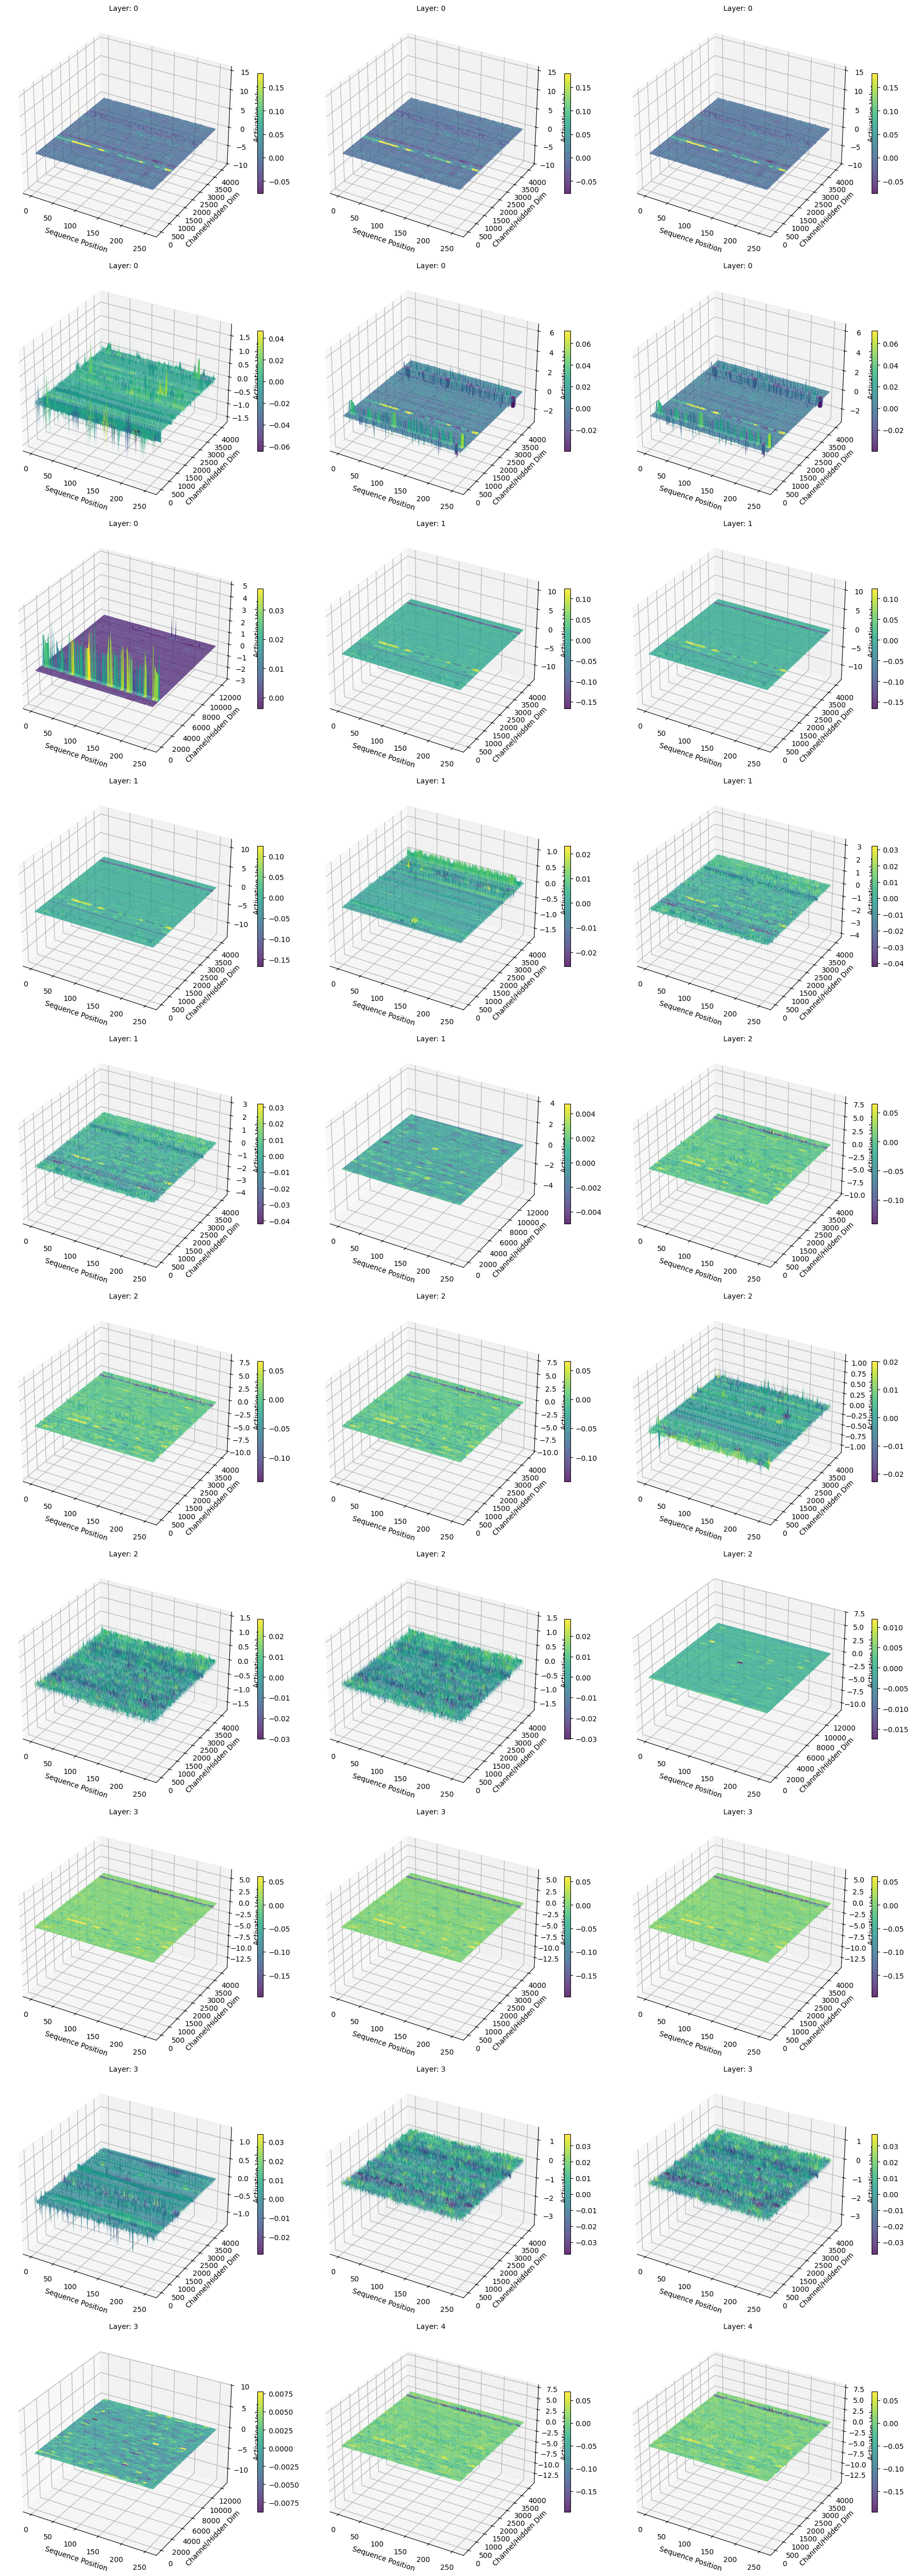

In [14]:
def plot_3d_activations_surface(activations, layer_names=None, max_layers=5):
    """
    Create 3D surface plots of activations.
    X-axis: Sequence position
    Y-axis: Channel/Hidden dimension
    Z-axis: Activation value
    Multiple layers shown as subplots.
    """
    if layer_names is None:
        layer_names = list(activations.keys())[:max_layers]
    
    n_layers = len(layer_names)
    cols = min(3, n_layers)
    rows = (n_layers + cols - 1) // cols
    
    fig = plt.figure(figsize=(6 * cols, 5 * rows))
    
    for idx, layer_name in enumerate(layer_names):
        if layer_name not in activations:
            continue
            
        act = activations[layer_name]
        
        # Handle different activation shapes
        if act.ndim == 2:
            # [seq_len, hidden_dim] - perfect for surface plot
            seq_len, hidden_dim = act.shape
            X = np.arange(seq_len)
            Y = np.arange(hidden_dim)
            X, Y = np.meshgrid(X, Y, indexing='ij')
            Z = act
        elif act.ndim == 1:
            # Flattened - reshape if possible
            if len(act) < 100:
                # Too small, skip or use scatter
                continue
            # Try to infer dimensions
            sqrt_len = int(np.sqrt(len(act)))
            if sqrt_len * sqrt_len == len(act):
                act_2d = act.reshape(sqrt_len, sqrt_len)
                seq_len, hidden_dim = act_2d.shape
                X = np.arange(seq_len)
                Y = np.arange(hidden_dim)
                X, Y = np.meshgrid(X, Y, indexing='ij')
                Z = act_2d
            else:
                continue
        else:
            continue
        
        ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
        ax.set_xlabel('Sequence Position')
        ax.set_ylabel('Channel/Hidden Dim')
        ax.set_zlabel('Activation Value')
        ax.set_title(f'Layer: {layer_name.split(".")[-2] if "." in layer_name else layer_name[:30]}', fontsize=10)
        fig.colorbar(surf, ax=ax, shrink=0.5)
    
    plt.tight_layout()
    return fig

# Create surface plots
if len(activations) > 0:
    print(activations.keys())
    layer_names = list(activations.keys())[:30]  # First 12 layers
    fig = plot_3d_activations_surface(activations, layer_names=layer_names)
    plt.show()
else:
    print("No activations captured for visualization")

--- Debugging Layer 0 ---
Layer 0 Output MSE: 0.000001
Layer 0 Max Delta: 0.015625


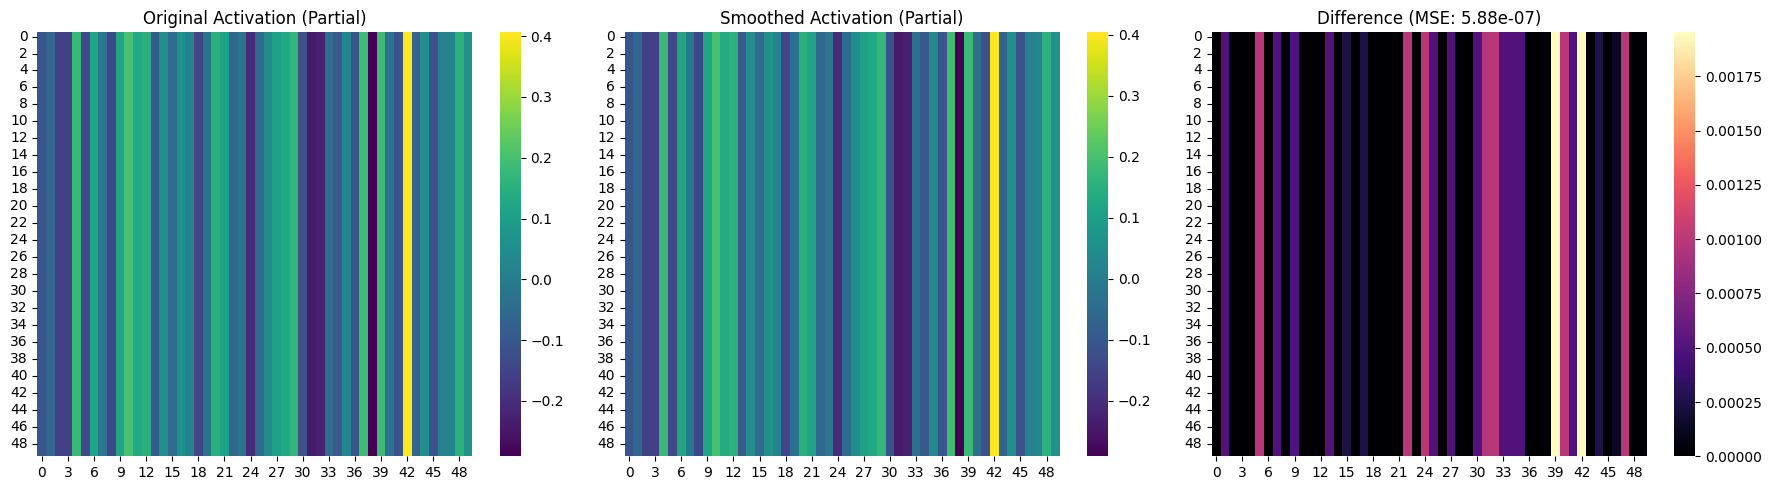

In [27]:
import seaborn as sns

class SmoothQuantDebugger:
    def __init__(self, original_model, smoothed_model):
        self.orig = original_model
        self.smooth = smoothed_model
        self.orig_activations = {}
        self.smooth_activations = {}
        
    def hook_layer_output(self, layer_idx):
        """Hooks the OUTPUT of a specific transformer block."""
        def get_hook(storage, key):
            def hook(module, input, output):
                # output is usually (hidden_states, ...) tuple
                if isinstance(output, tuple): 
                    val = output[0].detach().cpu()
                else: 
                    val = output.detach().cpu()
                storage[key] = val
            return hook

        # Locate blocks
        orig_block = self.orig.model.transformer.blocks[layer_idx]
        smooth_block = self.smooth.model.transformer.blocks[layer_idx]
        
        h1 = orig_block.register_forward_hook(get_hook(self.orig_activations, f"block_{layer_idx}"))
        h2 = smooth_block.register_forward_hook(get_hook(self.smooth_activations, f"block_{layer_idx}"))
        return [h1, h2]

    def visualize_divergence(self, input_ids, timestep=None, layer_idx=0):
        print(f"--- Debugging Layer {layer_idx} ---")
        
        # 1. Run Forward Passes
        with torch.no_grad():
            self.orig(input_ids=input_ids) # Add timestep if needed
            self.smooth(input_ids=input_ids)
            
        # 2. Get Data
        act_orig = self.orig_activations[f"block_{layer_idx}"].float()
        act_smooth = self.smooth_activations[f"block_{layer_idx}"].float()
        
        # 3. Compute Difference
        diff = torch.abs(act_orig - act_smooth)
        mse = torch.mean((act_orig - act_smooth)**2).item()
        max_diff = torch.max(diff).item()
        
        print(f"Layer {layer_idx} Output MSE: {mse:.6f}")
        print(f"Layer {layer_idx} Max Delta: {max_diff:.6f}")
        
        # 4. Visualization
        # Take the first token sequence in the batch [0, :, :]
        # Slice to [Seq_Len, Hidden_Dim]
        # We perform a small slice (e.g., first 50 tokens, first 50 dims) for clarity
        slice_seq, slice_dim = 50, 50
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot Original
        sns.heatmap(act_orig[0, :slice_seq, :slice_dim].numpy(), ax=axes[0], cmap="viridis")
        axes[0].set_title("Original Activation (Partial)")
        
        # Plot Smoothed
        sns.heatmap(act_smooth[0, :slice_seq, :slice_dim].numpy(), ax=axes[1], cmap="viridis")
        axes[1].set_title("Smoothed Activation (Partial)")
        
        # Plot Difference (The Smoking Gun)
        sns.heatmap(diff[0, :slice_seq, :slice_dim].numpy(), ax=axes[2], cmap="magma")
        axes[2].set_title(f"Difference (MSE: {mse:.2e})")
        
        plt.tight_layout()
        plt.show()

debugger = SmoothQuantDebugger(base_model, smoothed_model)
handles = debugger.hook_layer_output(layer_idx=0)
debugger.visualize_divergence(input_ids, layer_idx=0)

In [8]:
import torch

def find_break_point(original_model, smoothed_model, input_ids, threshold=0.1):
    print("\n=== Scanning for Break Point ===")
    
    # 1. Correctly locate modules based on your printout
    # Structure: LLaDAModel -> transformer (ModuleDict) -> wte / blocks
    
    # Access the inner LLaDAModel
    orig_base = original_model.model
    smooth_base = smoothed_model.model
    
    # Access the embeddings (inside the 'transformer' ModuleDict)
    # Note: ModuleDict items must be accessed via dictionary string keys, not attributes
    embed_orig = orig_base.transformer['wte']
    embed_smooth = smooth_base.transformer['wte']
    
    # Access the blocks (inside 'transformer' ModuleDict -> 'blocks' ModuleList)
    blocks_orig = orig_base.transformer['blocks']
    blocks_smooth = smooth_base.transformer['blocks']
    
    print(f"Total Blocks: {len(blocks_orig)}")

    # 2. Prepare hidden states (Output of Embeddings)
    print("Computing embeddings...")
    with torch.no_grad():
        hidden_orig = embed_orig(input_ids)
        hidden_smooth = embed_smooth(input_ids)
        
        # Initial Check: Do embeddings match?
        diff_emb = torch.abs(hidden_orig - hidden_smooth).max().item()
        print(f"Embedding Layer | Max Diff: {diff_emb:.6f}")
    
    # 3. Iterate Block by Block
    # We manually feed the hidden state from one block to the next
    for i, (b_orig, b_smooth) in enumerate(zip(blocks_orig, blocks_smooth)):
        
        with torch.no_grad():
            # Run forward pass on this specific block
            # Note: We pass only hidden_states. LLaDA blocks should auto-handle RoPE
            # if position_ids are missing (defaulting to 0..seq_len).
            
            # Output is typically a tuple (hidden_states, past_key_values, ...)
            out_orig = b_orig(hidden_orig)
            out_smooth = b_smooth(hidden_smooth)
            
            # Handle Tuple Returns
            if isinstance(out_orig, tuple):
                out_orig = out_orig[0]
            if isinstance(out_smooth, tuple):
                out_smooth = out_smooth[0]
            
            # Compare
            diff = torch.abs(out_orig - out_smooth)
            mse = torch.mean(diff**2).item()
            max_diff = torch.max(diff).item()
            
            print(f"Layer {i:02d} | MSE: {mse:.6f} | Max Diff: {max_diff:.4f}")
            
            # # STOP if we hit the explosion
            # if max_diff > 1.0:  # Threshold of 1.0 is a clear indicator of failure
            #     print(f"\n[!] FAILURE DETECTED AT LAYER {i}")
            #     print(f"    The error jumped to {max_diff:.4f}. Debug this block structure.")
                
            #     # --- Quick Diagnostic of the Broken Block ---
            #     print("\n    --- Diagnosing Weights in this Block ---")
                
            #     # Check MLP Down Projection (ff_out)
            #     w_orig = b_orig.ff_out.weight
            #     w_smooth = b_smooth.ff_out.weight
            #     w_diff = torch.abs(w_orig - w_smooth).max().item()
            #     print(f"    ff_out Weight Max Diff: {w_diff:.4f} (Should be small/zero if not smoothed)")
                
            #     # Check Up Projection (up_proj)
            #     w_orig = b_orig.up_proj.weight
            #     w_smooth = b_smooth.up_proj.weight
            #     w_diff = torch.abs(w_orig - w_smooth).max().item()
            #     print(f"    up_proj Weight Max Diff: {w_diff:.4f} (Should be large due to smoothing)")
                
                # return i
            
            # Pass the OUTPUT of the SMOOTHED model to the next layer
            # (We want to see if the error accumulates or explodes)
            hidden_orig = out_orig
            hidden_smooth = out_smooth

    print("\nScan complete. No massive explosions found in blocks.")
    return -1

# Run the scanner
find_break_point(base_model, smoothed_model, input_ids)


=== Scanning for Break Point ===
Total Blocks: 32
Computing embeddings...
Embedding Layer | Max Diff: 0.000000
Layer 00 | MSE: 0.000001 | Max Diff: 0.2500
Layer 01 | MSE: 0.000003 | Max Diff: 0.2500
Layer 02 | MSE: 0.000004 | Max Diff: 0.2500
Layer 03 | MSE: 0.000006 | Max Diff: 0.2500
Layer 04 | MSE: 0.000010 | Max Diff: 0.5000
Layer 05 | MSE: 0.000016 | Max Diff: 0.5000
Layer 06 | MSE: 0.000052 | Max Diff: 2.5000
Layer 07 | MSE: 0.000095 | Max Diff: 2.5000
Layer 08 | MSE: 0.000136 | Max Diff: 4.0000
Layer 09 | MSE: 0.000198 | Max Diff: 6.0000
Layer 10 | MSE: 0.000234 | Max Diff: 6.0000
Layer 11 | MSE: 0.000319 | Max Diff: 5.5000
Layer 12 | MSE: 0.000441 | Max Diff: 7.5000
Layer 13 | MSE: 0.000664 | Max Diff: 7.5000
Layer 14 | MSE: 0.001381 | Max Diff: 13.0000
Layer 15 | MSE: 0.002426 | Max Diff: 16.0000
Layer 16 | MSE: 0.003342 | Max Diff: 15.0000
Layer 17 | MSE: 0.005615 | Max Diff: 17.0000
Layer 18 | MSE: 0.008911 | Max Diff: 17.7500
Layer 19 | MSE: 0.015320 | Max Diff: 23.6250
La

-1

In [11]:
# Activation Merging Methods and Enhanced Visualization
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def merge_activations_sequence_concat(activations, layer_names=None):
    """
    Concatenate activations along sequence dimension (stack layers vertically).
    Result: [total_seq_len, hidden_dim] where total_seq_len = sum of all seq_lens
    Useful for seeing how patterns evolve across layers.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    merged = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                merged.append(act)
    
    if merged:
        return np.vstack(merged)  # Stack vertically
    return None


def merge_activations_hidden_concat(activations, layer_names=None):
    """
    Concatenate activations along hidden dimension (stack layers horizontally).
    Result: [seq_len, total_hidden_dim] where total_hidden_dim = sum of all hidden_dims
    Note: Requires all activations to have same seq_len
    Useful for seeing how different layers contribute to each position.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    merged = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                merged.append(act)
    
    if merged:
        # Check if all have same seq_len
        seq_lens = [a.shape[0] for a in merged]
        if len(set(seq_lens)) == 1:
            return np.hstack(merged)  # Stack horizontally
    return None


def merge_activations_mean(activations, layer_names=None):
    """
    Average activations across layers.
    Result: [seq_len, hidden_dim] - average activation pattern
    Note: Requires all activations to have same shape
    Most common method for overview visualization.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    activations_list = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                activations_list.append(act)
    
    if activations_list:
        # Check if all have same shape
        shapes = [a.shape for a in activations_list]
        if len(set(shapes)) == 1:
            return np.mean(activations_list, axis=0)
    return None


def merge_activations_weighted(activations, layer_names=None, weights=None):
    """
    Weighted combination of activations.
    weights: list of weights (will be normalized), or None for equal weights
    Useful when certain layers are more important.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    activations_list = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                activations_list.append(act)
    
    if activations_list:
        shapes = [a.shape for a in activations_list]
        if len(set(shapes)) == 1:
            if weights is None:
                weights = np.ones(len(activations_list))
            weights = np.array(weights) / np.sum(weights)  # Normalize
            
            result = np.zeros_like(activations_list[0])
            for act, w in zip(activations_list, weights):
                result += w * act
            return result
    return None


def merge_activations_stats(activations, layer_names=None, stat='std'):
    """
    Compute statistics across layers.
    stat: 'std', 'max', 'min', 'range' (max - min)
    Useful for seeing variance/consistency across layers.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    activations_list = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                activations_list.append(act)
    
    if activations_list:
        shapes = [a.shape for a in activations_list]
        if len(set(shapes)) == 1:
            stacked = np.stack(activations_list, axis=0)  # [n_layers, seq_len, hidden_dim]
            
            if stat == 'std':
                return np.std(stacked, axis=0)
            elif stat == 'max':
                return np.max(stacked, axis=0)
            elif stat == 'min':
                return np.min(stacked, axis=0)
            elif stat == 'range':
                return np.max(stacked, axis=0) - np.min(stacked, axis=0)
    return None


def merge_activations_3d(activations, layer_names=None):
    """
    Create 3D array with layer as third dimension.
    Result: [n_layers, seq_len, hidden_dim]
    Useful for 3D visualization with layer as third axis.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    activations_list = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                activations_list.append(act)
    
    if activations_list:
        shapes = [a.shape for a in activations_list]
        if len(set(shapes)) == 1:
            return np.stack(activations_list, axis=0)
    return None


def plot_merged_activations_surface(activations, layer_names=None, merge_method='mean', 
                                     max_layers=5, figsize=(15, 5)):
    """
    Create 3D surface plots of merged activations.
    
    Parameters:
    -----------
    activations : dict
        Dictionary mapping layer names to activation arrays
    layer_names : list, optional
        List of layer names to include. If None, uses all layers.
    merge_method : str
        Method to merge activations:
        - 'mean': Average across layers (default)
        - 'concat_seq': Concatenate along sequence dimension
        - 'concat_hidden': Concatenate along hidden dimension
        - 'std': Standard deviation across layers
        - 'max': Maximum across layers
        - 'min': Minimum across layers
        - 'range': Range (max - min) across layers
        - 'weighted': Weighted combination (requires weights parameter)
        - 'none': Plot individual layers (original behavior)
    max_layers : int
        Maximum number of layers to plot when merge_method='none'
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    if layer_names is None:
        layer_names = list(activations.keys())[:max_layers]
    
    # Handle different merge methods
    if merge_method == 'none':
        # Original behavior: plot individual layers
        n_layers = len(layer_names)
        cols = min(3, n_layers)
        rows = (n_layers + cols - 1) // cols
        
        fig = plt.figure(figsize=(6 * cols, 5 * rows))
        
        for idx, layer_name in enumerate(layer_names):
            if layer_name not in activations:
                continue
                
            act = activations[layer_name]
            
            # Handle different activation shapes
            if act.ndim == 2:
                seq_len, hidden_dim = act.shape
                X = np.arange(seq_len)
                Y = np.arange(hidden_dim)
                X, Y = np.meshgrid(X, Y, indexing='ij')
                Z = act
            elif act.ndim == 1:
                if len(act) < 100:
                    continue
                sqrt_len = int(np.sqrt(len(act)))
                if sqrt_len * sqrt_len == len(act):
                    act_2d = act.reshape(sqrt_len, sqrt_len)
                    seq_len, hidden_dim = act_2d.shape
                    X = np.arange(seq_len)
                    Y = np.arange(hidden_dim)
                    X, Y = np.meshgrid(X, Y, indexing='ij')
                    Z = act_2d
                else:
                    continue
            else:
                continue
            
            ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
            surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
            ax.set_xlabel('Sequence Position')
            ax.set_ylabel('Channel/Hidden Dim')
            ax.set_zlabel('Activation Value')
            ax.set_title(f'Layer: {layer_name.split(".")[-2] if "." in layer_name else layer_name[:30]}', fontsize=10)
            fig.colorbar(surf, ax=ax, shrink=0.5)
        
        plt.tight_layout()
        return fig
    
    # Apply merge method
    if merge_method == 'mean':
        merged = merge_activations_mean(activations, layer_names)
        title = f'Merged Activations (Mean across {len(layer_names)} layers)'
    elif merge_method == 'concat_seq':
        merged = merge_activations_sequence_concat(activations, layer_names)
        title = f'Merged Activations (Sequence Concat, {len(layer_names)} layers)'
    elif merge_method == 'concat_hidden':
        merged = merge_activations_hidden_concat(activations, layer_names)
        title = f'Merged Activations (Hidden Concat, {len(layer_names)} layers)'
    elif merge_method in ['std', 'max', 'min', 'range']:
        merged = merge_activations_stats(activations, layer_names, stat=merge_method)
        title = f'Merged Activations ({merge_method.upper()} across {len(layer_names)} layers)'
    else:
        raise ValueError(f"Unknown merge_method: {merge_method}")
    
    if merged is None:
        print(f"Warning: Could not merge activations with method '{merge_method}'. "
              f"Activations may have incompatible shapes.")
        return None
    
    # Create single 3D surface plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    seq_len, hidden_dim = merged.shape
    X = np.arange(seq_len)
    Y = np.arange(hidden_dim)
    X, Y = np.meshgrid(X, Y, indexing='ij')
    Z = merged
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
    ax.set_xlabel('Sequence Position', fontsize=12)
    ax.set_ylabel('Channel/Hidden Dim', fontsize=12)
    ax.set_zlabel('Activation Value', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20)
    
    plt.tight_layout()
    return fig


# Example usage:
print("Activation merging functions defined!")
print("\nAvailable merge methods:")
print("  - 'mean': Average across layers (recommended for overview)")
print("  - 'concat_seq': Concatenate along sequence dimension (shows evolution)")
print("  - 'concat_hidden': Concatenate along hidden dimension")
print("  - 'std': Standard deviation (shows variance)")
print("  - 'max': Maximum across layers")
print("  - 'min': Minimum across layers")
print("  - 'range': Range (max - min)")
print("  - 'none': Plot individual layers (original behavior)")


Activation merging functions defined!

Available merge methods:
  - 'mean': Average across layers (recommended for overview)
  - 'concat_seq': Concatenate along sequence dimension (shows evolution)
  - 'concat_hidden': Concatenate along hidden dimension
  - 'std': Standard deviation (shows variance)
  - 'max': Maximum across layers
  - 'min': Minimum across layers
  - 'range': Range (max - min)
  - 'none': Plot individual layers (original behavior)


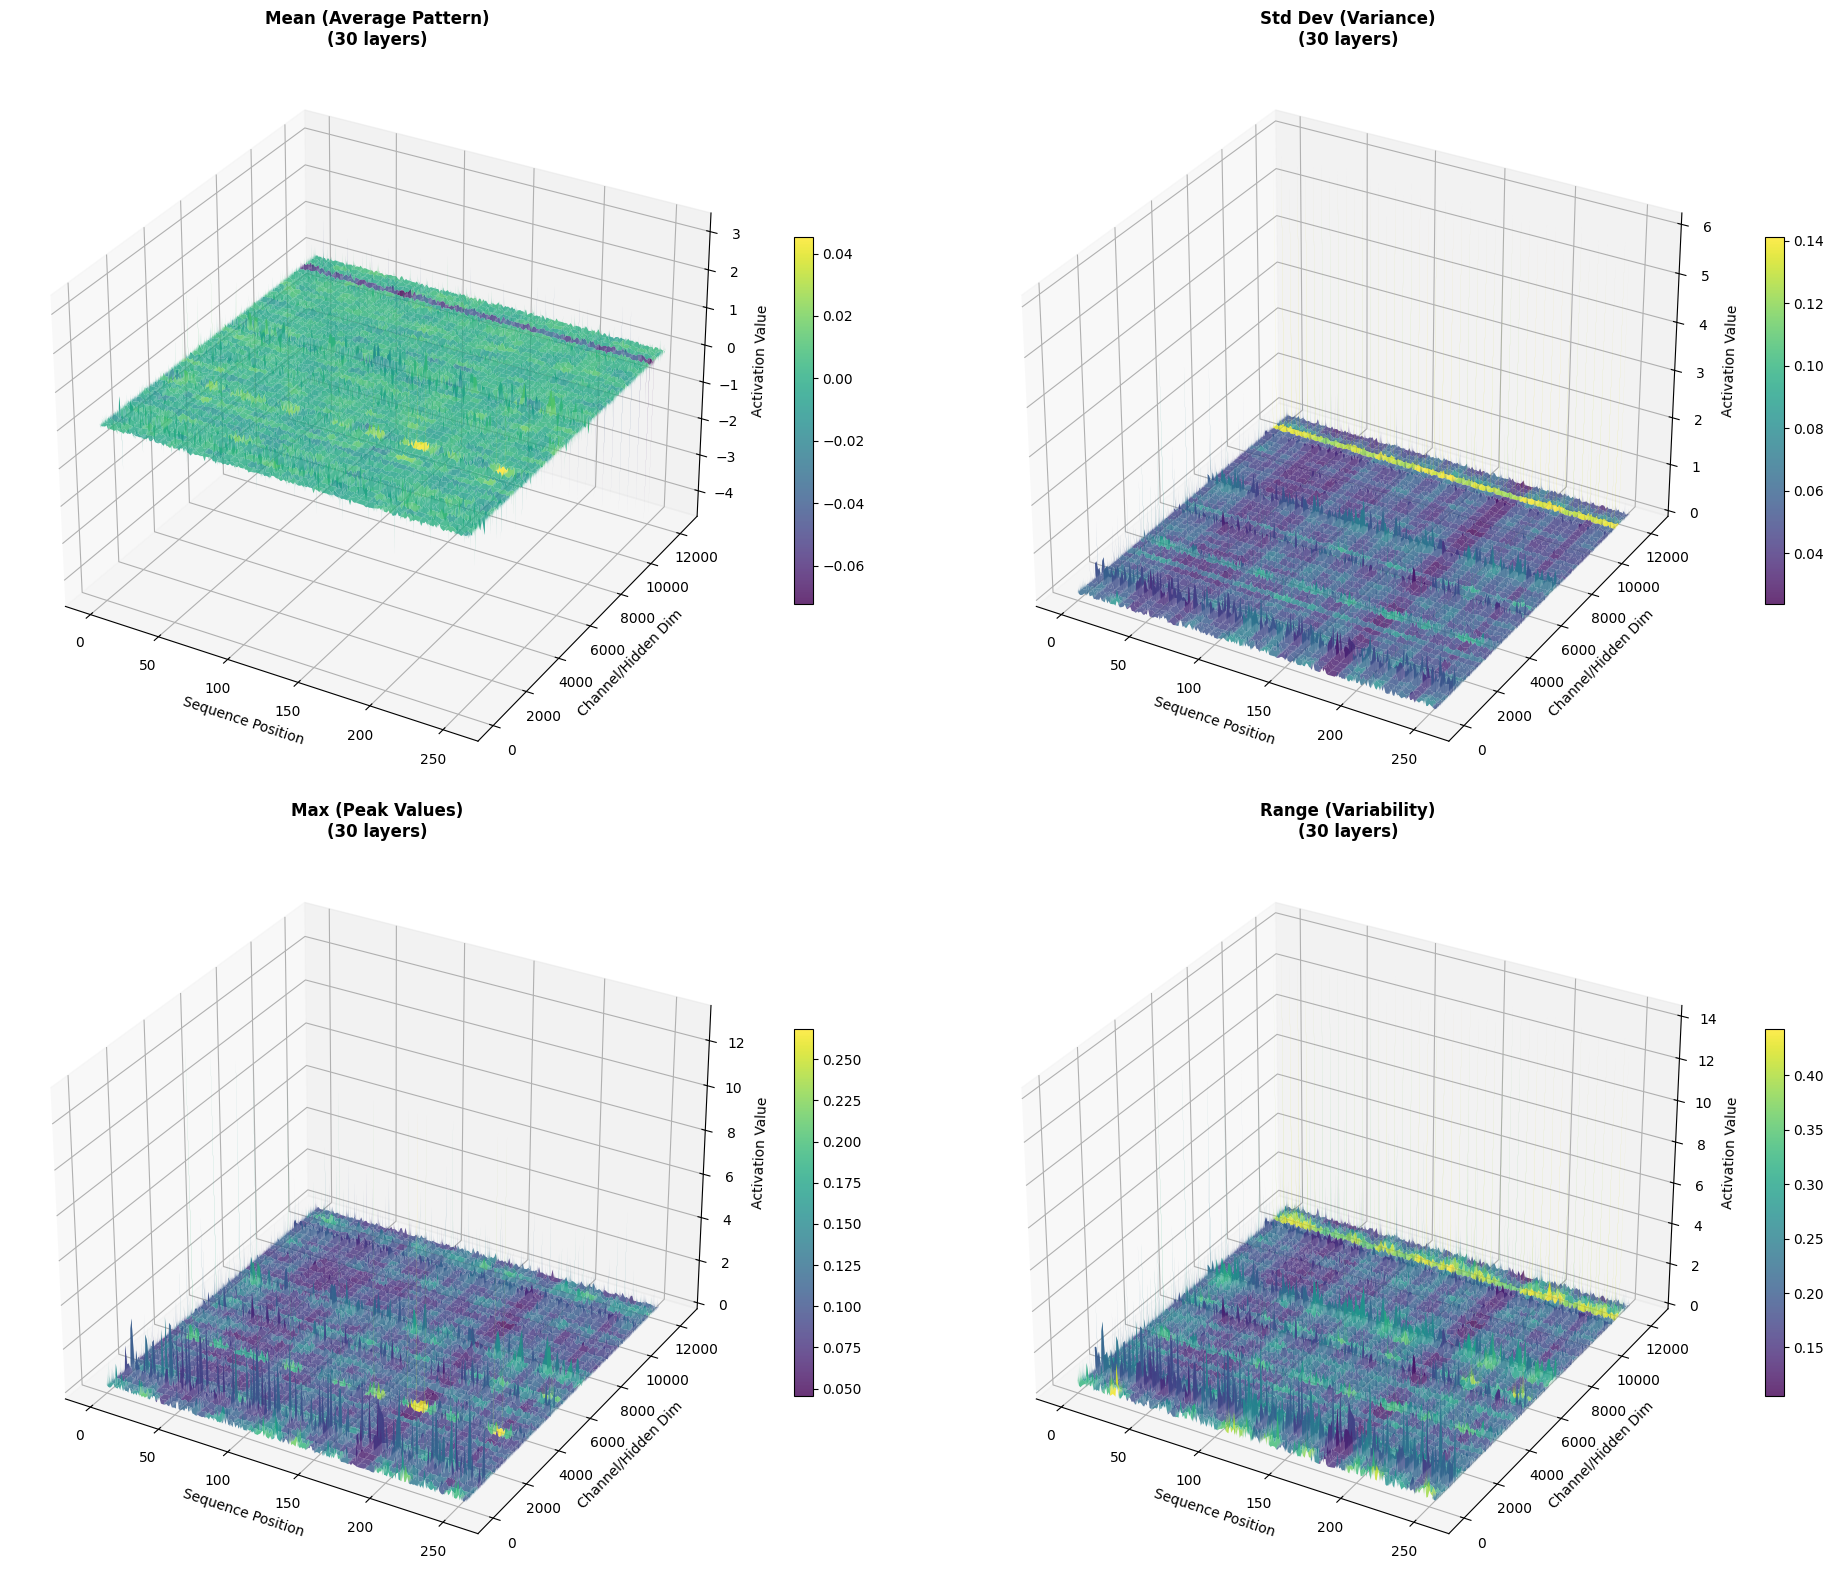


Sequence Concatenation Method (shows layer evolution)


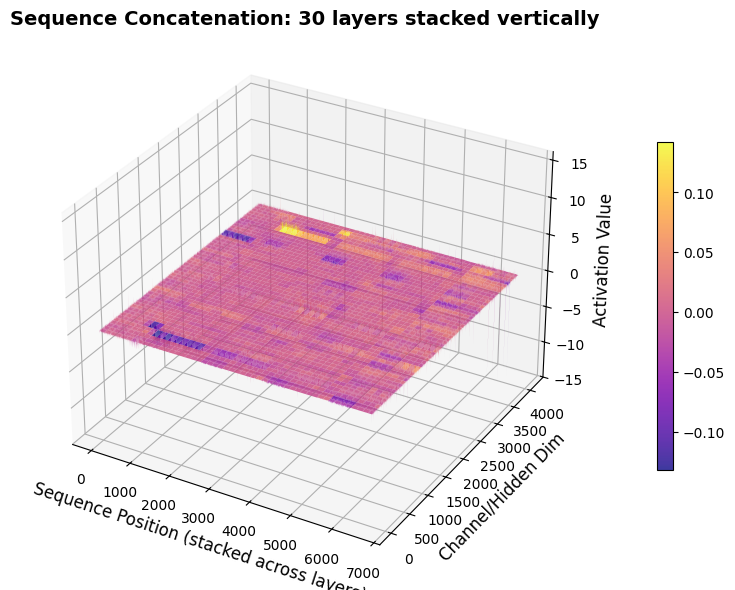


Using plot_merged_activations_surface function


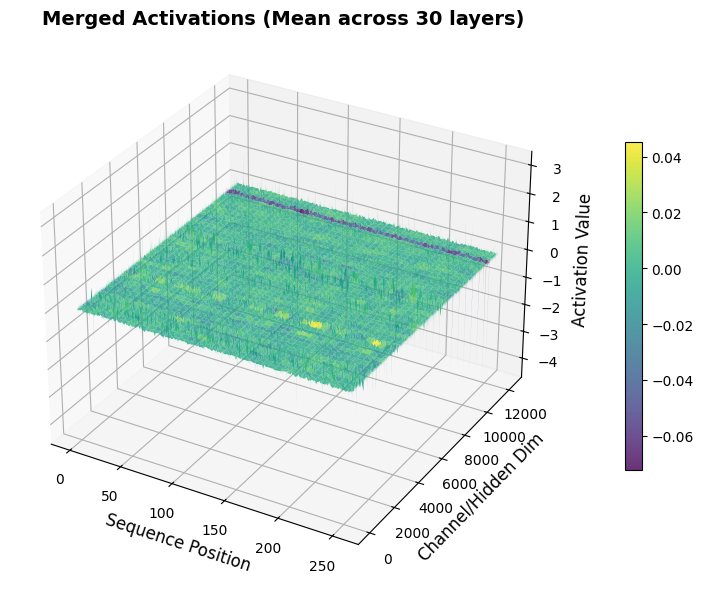

In [14]:
# Demonstrate merged activation visualizations
if len(activations) > 0:
    layer_names = list(activations.keys())[:30]  # Use first 30 layers
    
    # Create a figure with multiple merge methods
    fig, axes = plt.subplots(2, 2, figsize=(20, 16), subplot_kw={'projection': '3d'})
    axes = axes.flatten()
    
    merge_methods = ['mean', 'std', 'max', 'range']
    titles = ['Mean (Average Pattern)', 'Std Dev (Variance)', 'Max (Peak Values)', 'Range (Variability)']
    
    for idx, (method, title) in enumerate(zip(merge_methods, titles)):
        merged = None
        if method == 'mean':
            merged = merge_activations_mean(activations, layer_names)
        elif method in ['std', 'max', 'range']:
            merged = merge_activations_stats(activations, layer_names, stat=method)
        
        if merged is not None:
            ax = axes[idx]
            seq_len, hidden_dim = merged.shape
            X = np.arange(seq_len)
            Y = np.arange(hidden_dim)
            X, Y = np.meshgrid(X, Y, indexing='ij')
            Z = merged
            
            surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)
            ax.set_xlabel('Sequence Position', fontsize=10)
            ax.set_ylabel('Channel/Hidden Dim', fontsize=10)
            ax.set_zlabel('Activation Value', fontsize=10)
            ax.set_title(f'{title}\n({len(layer_names)} layers)', fontsize=12, fontweight='bold')
            fig.colorbar(surf, ax=ax, shrink=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Also show sequence concatenation method
    print("\n" + "="*60)
    print("Sequence Concatenation Method (shows layer evolution)")
    print("="*60)
    merged_seq = merge_activations_sequence_concat(activations, layer_names)
    if merged_seq is not None:
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        seq_len, hidden_dim = merged_seq.shape
        X = np.arange(seq_len)
        Y = np.arange(hidden_dim)
        X, Y = np.meshgrid(X, Y, indexing='ij')
        Z = merged_seq
        
        surf = ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.8, linewidth=0, antialiased=True)
        ax.set_xlabel('Sequence Position (stacked across layers)', fontsize=12)
        ax.set_ylabel('Channel/Hidden Dim', fontsize=12)
        ax.set_zlabel('Activation Value', fontsize=12)
        ax.set_title(f'Sequence Concatenation: {len(layer_names)} layers stacked vertically', 
                     fontsize=14, fontweight='bold')
        fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20)
        plt.tight_layout()
        plt.show()
    
    # Show individual merged plot using the new function
    print("\n" + "="*60)
    print("Using plot_merged_activations_surface function")
    print("="*60)
    fig = plot_merged_activations_surface(activations, layer_names=layer_names, 
                                          merge_method='mean', figsize=(14, 6))
    if fig:
        plt.show()
        
else:
    print("No activations captured for visualization")


In [13]:
# FIXED: Merge functions that handle dimension mismatches
# These versions handle cases where different layers have different hidden dimensions

def merge_activations_mean_fixed(activations, layer_names=None, resize_mode='max'):
    """
    Average activations across layers, handling dimension mismatches.
    
    Parameters:
    -----------
    resize_mode : str
        'max' - resize all to largest dimensions (default)
        'min' - resize all to smallest dimensions
        'group' - only merge layers with matching shapes
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    activations_list = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                activations_list.append(act)
    
    if not activations_list:
        return None
    
    if resize_mode == 'group':
        # Group by shape and use the largest group
        from collections import defaultdict
        groups = defaultdict(list)
        for act in activations_list:
            groups[act.shape].append(act)
        if not groups:
            return None
        # Use the group with most activations
        best_group = max(groups.values(), key=len)
        return np.mean(best_group, axis=0)
    
    # Resize all to common shape
    if resize_mode == 'max':
        target_shape = (max(a.shape[0] for a in activations_list), 
                       max(a.shape[1] for a in activations_list))
    else:  # min
        target_shape = (min(a.shape[0] for a in activations_list), 
                       min(a.shape[1] for a in activations_list))
    
    # Resize all activations to target shape
    try:
        from scipy.ndimage import zoom
        resized = []
        for act in activations_list:
            if act.shape == target_shape:
                resized.append(act)
            else:
                zoom_factors = (target_shape[0] / act.shape[0], 
                               target_shape[1] / act.shape[1])
                resized.append(zoom(act, zoom_factors, order=1))
        return np.mean(resized, axis=0)
    except ImportError:
        # Fallback: only use activations with matching shapes
        shapes = [a.shape for a in activations_list]
        from collections import Counter
        most_common_shape = Counter(shapes).most_common(1)[0][0]
        matching = [a for a in activations_list if a.shape == most_common_shape]
        if matching:
            return np.mean(matching, axis=0)
    return None


def merge_activations_sequence_concat_fixed(activations, layer_names=None):
    """
    Concatenate activations along sequence dimension.
    Only concatenates layers with matching hidden_dim.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    # Group by hidden_dim
    from collections import defaultdict
    groups = defaultdict(list)
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                hidden_dim = act.shape[1]
                groups[hidden_dim].append(act)
    
    if not groups:
        return None
    
    # Use the group with the most layers
    best_group = max(groups.values(), key=len)
    if best_group:
        return np.vstack(best_group)
    return None


def merge_activations_hidden_concat_fixed(activations, layer_names=None):
    """
    Concatenate activations along hidden dimension.
    Only concatenates layers with matching seq_len.
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    # Group by seq_len
    from collections import defaultdict
    groups = defaultdict(list)
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                seq_len = act.shape[0]
                groups[seq_len].append(act)
    
    if not groups:
        return None
    
    # Use the group with the most layers
    best_group = max(groups.values(), key=len)
    if best_group:
        return np.hstack(best_group)
    return None


def merge_activations_stats_fixed(activations, layer_names=None, stat='std', resize_mode='max'):
    """
    Compute statistics across layers, handling dimension mismatches.
    stat: 'std', 'max', 'min', 'range'
    resize_mode: 'max', 'min', or 'group'
    """
    if layer_names is None:
        layer_names = list(activations.keys())
    
    activations_list = []
    for layer_name in layer_names:
        if layer_name in activations:
            act = activations[layer_name]
            if act.ndim == 2:
                activations_list.append(act)
    
    if not activations_list:
        return None
    
    if resize_mode == 'group':
        # Group by shape and use the largest group
        from collections import defaultdict
        groups = defaultdict(list)
        for act in activations_list:
            groups[act.shape].append(act)
        if not groups:
            return None
        best_group = max(groups.values(), key=len)
        stacked = np.stack(best_group, axis=0)
    else:
        # Resize all to common shape
        if resize_mode == 'max':
            target_shape = (max(a.shape[0] for a in activations_list), 
                           max(a.shape[1] for a in activations_list))
        else:  # min
            target_shape = (min(a.shape[0] for a in activations_list), 
                           min(a.shape[1] for a in activations_list))
        
        try:
            from scipy.ndimage import zoom
            resized = []
            for act in activations_list:
                if act.shape == target_shape:
                    resized.append(act)
                else:
                    zoom_factors = (target_shape[0] / act.shape[0], 
                                   target_shape[1] / act.shape[1])
                    resized.append(zoom(act, zoom_factors, order=1))
            stacked = np.stack(resized, axis=0)
        except ImportError:
            # Fallback: only use activations with matching shapes
            shapes = [a.shape for a in activations_list]
            from collections import Counter
            most_common_shape = Counter(shapes).most_common(1)[0][0]
            matching = [a for a in activations_list if a.shape == most_common_shape]
            if not matching:
                return None
            stacked = np.stack(matching, axis=0)
    
    # Compute statistics
    if stat == 'std':
        return np.std(stacked, axis=0)
    elif stat == 'max':
        return np.max(stacked, axis=0)
    elif stat == 'min':
        return np.min(stacked, axis=0)
    elif stat == 'range':
        return np.max(stacked, axis=0) - np.min(stacked, axis=0)
    return None


# Update the original functions to use the fixed versions
merge_activations_mean = merge_activations_mean_fixed
merge_activations_sequence_concat = merge_activations_sequence_concat_fixed
merge_activations_hidden_concat = merge_activations_hidden_concat_fixed
merge_activations_stats = merge_activations_stats_fixed

print("Fixed merge functions loaded! These handle dimension mismatches.")
print("Note: Functions will group by shape or resize to common dimensions.")


Fixed merge functions loaded! These handle dimension mismatches.
Note: Functions will group by shape or resize to common dimensions.


In [ ]:
# Visualize Activation Outlier Spikes in Later Layers
import numpy as np
import matplotlib.pyplot as plt

def analyze_activation_outliers(activations, layer_names=None, percentile_threshold=99.5, 
                                 top_n_layers=10, start_from_layer=None):
    """
    Analyze and visualize activation outliers across layers.
    """
    if layer_names is None:
        all_layers = list(activations.keys())
        if start_from_layer is not None:
            layer_names = all_layers[start_from_layer:]
        else:
            layer_names = all_layers[len(all_layers)//2:]
    
    layer_names = layer_names[:top_n_layers]
    print(f"Analyzing {len(layer_names)} layers for outlier spikes...")
    
    layer_stats = []
    for layer_name in layer_names:
        if layer_name not in activations:
            continue
        act = activations[layer_name]
        if act.ndim != 2:
            continue
        
        channel_max = np.max(np.abs(act), axis=0)
        channel_mean = np.mean(np.abs(act), axis=0)
        global_max = np.max(np.abs(act))
        global_mean = np.mean(np.abs(act))
        threshold = np.percentile(np.abs(act), percentile_threshold)
        outlier_count = np.sum(np.abs(act) > threshold)
        outlier_ratio = outlier_count / act.size
        channel_outlier_threshold = np.percentile(channel_max, 95)
        outlier_channels = np.where(channel_max > channel_outlier_threshold)[0]
        
        layer_stats.append({
            'name': layer_name,
            'short_name': layer_name.split('.')[-2] if '.' in layer_name else layer_name[:25],
            'shape': act.shape,
            'global_max': global_max,
            'global_mean': global_mean,
            'outlier_ratio': outlier_ratio,
            'channel_max': channel_max,
            'channel_mean': channel_mean,
            'outlier_channels': outlier_channels,
            'activation': act
        })
    return layer_stats


def plot_outlier_analysis(layer_stats, figsize=(18, 12)):
    """Create comprehensive outlier visualization."""
    n_layers = len(layer_stats)
    if n_layers == 0:
        print("No layers to visualize")
        return None
    
    fig = plt.figure(figsize=figsize)
    
    # 1. Bar chart of max activation per layer
    ax1 = fig.add_subplot(2, 3, 1)
    names = [s['short_name'] for s in layer_stats]
    max_vals = [s['global_max'] for s in layer_stats]
    colors = ['red' if v > np.percentile(max_vals, 90) else 'steelblue' for v in max_vals]
    ax1.barh(range(len(names)), max_vals, color=colors)
    ax1.set_yticks(range(len(names)))
    ax1.set_yticklabels(names, fontsize=8)
    ax1.set_xlabel('Max |Activation|')
    ax1.set_title('Max Activation per Layer (Red = Top 10%)', fontweight='bold')
    ax1.invert_yaxis()
    
    # 2. Outlier ratio per layer
    ax2 = fig.add_subplot(2, 3, 2)
    outlier_ratios = [s['outlier_ratio'] * 100 for s in layer_stats]
    ax2.barh(range(len(names)), outlier_ratios, color='coral')
    ax2.set_yticks(range(len(names)))
    ax2.set_yticklabels(names, fontsize=8)
    ax2.set_xlabel('Outlier Ratio (%)')
    ax2.set_title('Outlier Ratio (>99.5th percentile)', fontweight='bold')
    ax2.invert_yaxis()
    
    # 3. Top outlier channels for worst layer
    ax3 = fig.add_subplot(2, 3, 3)
    worst_layer = max(layer_stats, key=lambda x: x['global_max'])
    channel_max = worst_layer['channel_max']
    top_k = min(50, len(channel_max))
    top_indices = np.argsort(channel_max)[-top_k:][::-1]
    ax3.bar(range(top_k), channel_max[top_indices], color='crimson', alpha=0.7)
    ax3.set_xlabel('Top Outlier Channels')
    ax3.set_ylabel('Max |Activation|')
    ax3.set_title(f'Top {top_k} Channels ({worst_layer["short_name"]})', fontweight='bold')
    
    # 4. Heatmap for worst layer
    ax4 = fig.add_subplot(2, 3, 4)
    act = worst_layer['activation']
    step_seq = max(1, act.shape[0] // 128) if act.shape[0] > 128 else 1
    act_display = act[::step_seq, :]
    step_hidden = max(1, act_display.shape[1] // 256) if act_display.shape[1] > 256 else 1
    act_display = act_display[:, ::step_hidden]
    im = ax4.imshow(np.abs(act_display).T, aspect='auto', cmap='hot', interpolation='nearest')
    ax4.set_xlabel('Sequence Position')
    ax4.set_ylabel('Channel')
    ax4.set_title(f'Activation Heatmap ({worst_layer["short_name"]})', fontweight='bold')
    plt.colorbar(im, ax=ax4, shrink=0.8)
    
    # 5. Distribution of activations
    ax5 = fig.add_subplot(2, 3, 5)
    all_acts = np.concatenate([s['activation'].flatten()[:10000] for s in layer_stats[:5]])
    ax5.hist(np.abs(all_acts), bins=100, color='steelblue', alpha=0.7, log=True)
    p995 = np.percentile(np.abs(all_acts), 99.5)
    p999 = np.percentile(np.abs(all_acts), 99.9)
    ax5.axvline(p995, color='red', linestyle='--', label=f'99.5th: {p995:.2f}')
    ax5.axvline(p999, color='darkred', linestyle='--', label=f'99.9th: {p999:.2f}')
    ax5.set_xlabel('|Activation|')
    ax5.set_ylabel('Count (log)')
    ax5.set_title('Activation Distribution', fontweight='bold')
    ax5.legend(fontsize=8)
    
    # 6. Channel max distribution (sorted)
    ax6 = fig.add_subplot(2, 3, 6)
    channel_max_sorted = np.sort(worst_layer['channel_max'])[::-1]
    ax6.semilogy(channel_max_sorted, color='crimson', linewidth=1.5)
    ax6.fill_between(range(len(channel_max_sorted)), channel_max_sorted, alpha=0.3, color='crimson')
    ax6.set_xlabel('Channel Rank')
    ax6.set_ylabel('Max |Activation| (log)')
    ax6.set_title(f'Channel Distribution ({worst_layer["short_name"]})', fontweight='bold')
    
    plt.tight_layout()
    return fig


def plot_individual_layer_outliers(activations, layer_names, figsize=(16, 4)):
    """Plot per-channel max for individual layers, highlighting outliers."""
    n_layers = len(layer_names)
    fig, axes = plt.subplots(1, n_layers, figsize=(figsize[0], figsize[1]))
    if n_layers == 1:
        axes = [axes]
    
    for idx, layer_name in enumerate(layer_names):
        if layer_name not in activations:
            continue
        act = activations[layer_name]
        if act.ndim != 2:
            continue
        
        ax = axes[idx]
        channel_max = np.max(np.abs(act), axis=0)
        ax.bar(range(len(channel_max)), channel_max, width=1.0, color='steelblue', alpha=0.7)
        threshold = np.percentile(channel_max, 95)
        outlier_mask = channel_max > threshold
        ax.bar(np.where(outlier_mask)[0], channel_max[outlier_mask], width=1.0, color='red', alpha=0.8)
        ax.axhline(threshold, color='red', linestyle='--', linewidth=1, alpha=0.7)
        ax.set_xlabel('Channel')
        ax.set_ylabel('Max |Act|')
        short_name = layer_name.split('.')[-2] if '.' in layer_name else layer_name[:15]
        ax.set_title(f'{short_name}\nMax: {np.max(channel_max):.2f}', fontsize=9)
    
    plt.suptitle('Per-Channel Max Activation (Red = Outliers >95th percentile)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig


# Run the analysis
if len(activations) > 0:
    print("=" * 60)
    print("ACTIVATION OUTLIER ANALYSIS - LATER LAYERS")
    print("=" * 60)
    
    all_layer_names = list(activations.keys())
    later_layers = all_layer_names[len(all_layer_names)//2:]
    layer_stats = analyze_activation_outliers(activations, layer_names=later_layers, top_n_layers=15)
    
    if layer_stats:
        fig = plot_outlier_analysis(layer_stats)
        plt.show()
        
        print("\n" + "=" * 80)
        print("OUTLIER SUMMARY TABLE")
        print("=" * 80)
        print(f"{'Layer':<35} {'Shape':<18} {'Max':>10} {'Mean':>10} {'Outlier%':>10}")
        print("-" * 80)
        for s in sorted(layer_stats, key=lambda x: x['global_max'], reverse=True):
            print(f"{s['short_name']:<35} {str(s['shape']):<18} {s['global_max']:>10.2f} "
                  f"{s['global_mean']:>10.4f} {s['outlier_ratio']*100:>9.4f}%")
        
        print("\n" + "=" * 60)
        print("TOP 5 LAYERS WITH HIGHEST ACTIVATION SPIKES")
        print("=" * 60)
        worst_5 = sorted(layer_stats, key=lambda x: x['global_max'], reverse=True)[:5]
        worst_5_names = [s['name'] for s in worst_5]
        fig2 = plot_individual_layer_outliers(activations, worst_5_names)
        plt.show()
else:
    print("No activations available. Run activation capture first.")